[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed


Mean Absolute Error: 0.9594915550534087
Mean Squared Error: 1.8310117178122103


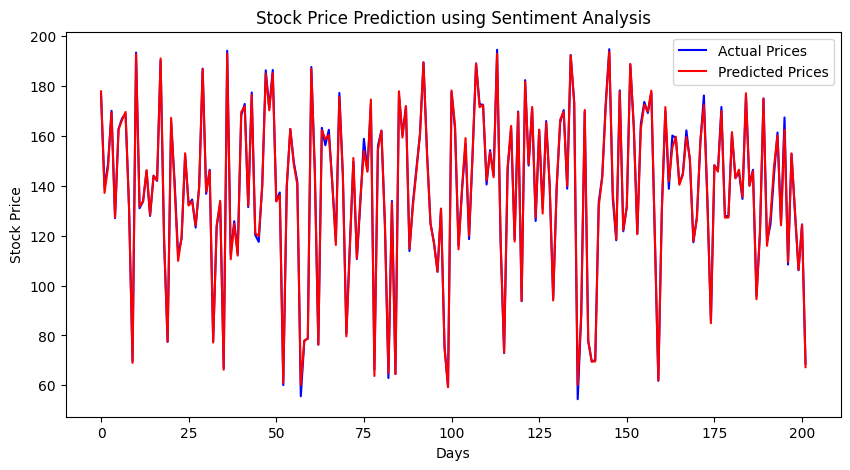

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Download and initialize Sentiment Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    """Extract sentiment score from text."""
    return sia.polarity_scores(str(text))['compound']  # Ensure text is string

# Load dataset without headers
file_path ='/content/all-data.csv'
news_df = pd.read_csv(file_path, encoding="ISO-8859-1", header=None)

# Rename columns based on observation
news_df.columns = ['sentiment_label', 'headline']

# Assign sequential dates assuming one news item per day (Adjust as needed)
start_date = "2020-01-01"
news_df['date'] = pd.date_range(start=start_date, periods=len(news_df), freq='D')

# Apply sentiment analysis
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Load stock price data
ticker = "AAPL"
stock_data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Reset index to remove MultiIndex issue
stock_data = stock_data.reset_index()

# If there's still a MultiIndex, drop extra levels
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)  # Flatten columns

# Convert date columns to the same format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
news_df['date'] = pd.to_datetime(news_df['date'])

# Aggregate sentiment per day (if multiple news per day)
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()

# Merge the datasets correctly
merged_df = pd.merge(daily_sentiment, stock_data, left_on='date', right_on='Date', how='inner')

# Feature selection
features = ['sentiment', 'Open', 'High', 'Low', 'Volume']
target = 'Close'

# Drop missing values
merged_df.dropna(subset=features + [target], inplace=True)

# Prepare data
X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train predictive model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted stock prices
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.values, label='Actual Prices', color='blue')
plt.plot(range(len(y_test)), y_pred, label='Predicted Prices', color='red')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Stock Price Prediction using Sentiment Analysis')
plt.show()